In [211]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### prepare the TFD/E results

In [212]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/P3856'
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [213]:
len(results_df)

23295

In [214]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [215]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)

In [216]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [217]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [218]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [219]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,extractions_l,ext_count_all_runs,ext_count_human_only_runs
11990,LLYDTFSAFGVILQTPK,3,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,18,0,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10
17306,SCPDQPSEILSDYIQQSTM[15.9949]GR,2,"{""perc_q_value"": 0.0017506082000000001, ""run_n...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 0.0017506082000000001, 'run_n...",0.001751,3,1,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",29,9
6391,FTVVSDPPEDEQDLECEDIGVAHVDLADM[15.9949]FQEGR,3,"{""perc_q_value"": 0.00035062974999999996, ""run_...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 0.00035062974999999996, 'run_...",0.000351,1,0,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",17,0


In [220]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [221]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [222]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/experiments/P3856/evidence-P3856.txt', sep='\\t', engine='python')

In [223]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [225]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [226]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [227]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [228]:
merged_df = pd.merge(sorted_counts_df, mq_sorted_counts_df, how='inner', left_on=['run_name'], right_on=['run_name'], suffixes=['_tfd_e','_mq'])
merged_df.index = merged_df.run_name

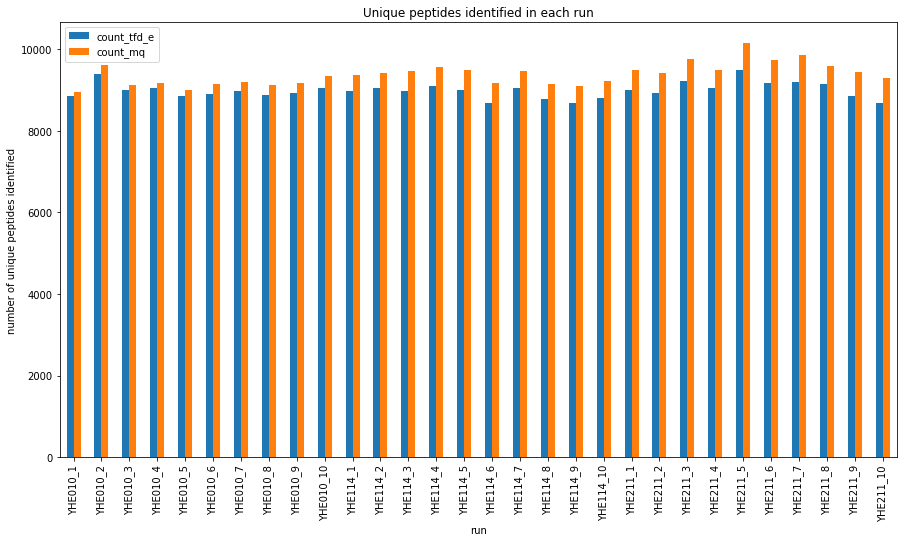

In [229]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

In [230]:
merged_df[merged_df.run_name == 'YHE211_1']

,run_name,count_tfd_e,count_mq
run_name,,,
YHE211_1,YHE211_1,8995,9489


## missing-ness heatmaps

In [233]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    result = False
    identification_groups_l = list(set([r.split('_')[1] for r in identification_run_names_l]))
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

#### prepare the TFD/E data

In [231]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [232]:
results_df.iloc[0].extractions_l

[{'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',
  'prob_target': 0.5535360344747312,
  'intensity': 181,
  'inferred': 0}]

In [235]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, short_run_name, group_name, extraction['intensity']))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'short_run_name', 'group','intensity'])


In [236]:
sequences_df.sample(n=5)

,sequence,charge,id_perc_q_value,short_run_name,group,intensity
282010,LLGIFENQDR,2,0.000115,YHE211_10,YHE211,338
68828,DLKPENILVDNDFHIK,3,0.000022,YHE114_3,YHE114,453
399968,RDDGYEAAASSK,2,0.000004,YHE010_7,YHE010,4239
481406,TVSSSNGGESSSR,2,0.002166,YHE114_2,YHE114,482
182102,GQVVENNSVTEFSEEK,2,0.000004,YHE211_4,YHE211,1002


In [237]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [238]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [239]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
20271,GVEVVLPVDFIIADAFSADANTK,2,YHE114,68.0
24941,ILNVSHNHISHIPK,2,YHE114,66.0
3021,APCILLYISSFTTDFLAVLVKPTGSLQIRYNLGGTR,4,YHE114,65.0
24320,IHLAQSLHK,2,YHE211,58.0
51198,TPSECLLTPLPPSALPSADDNLK,3,YHE211,25.0


In [240]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [241]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

## TFD/E heatmaps

#### plot YHE010

In [242]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [243]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [244]:
occurences_df.head()

,YHE010_1,YHE010_2,YHE010_3,YHE010_4,YHE010_5,YHE010_6,YHE010_7,YHE010_8,YHE010_9,YHE010_10
"VQSSYLHSLLEMGELLK,3",0.000000,8.693487,8.854868,0.000000,0.000000,0.000000,8.400879,9.047124,0.000000,8.758223
"SYGLSVVPEPAGCTPELPGEIIK,2",8.252665,8.816984,8.611025,8.903882,9.052568,8.622052,8.836050,8.727920,8.546894,9.098032
"DSWLDNIDWVK,2",7.651052,8.845490,7.930737,8.344296,9.177420,8.573647,8.778077,10.048487,8.383704,8.366322
"ELEFLSMANVELSSLAR,2",8.144658,8.134426,7.459432,10.005625,7.965784,8.144658,9.296916,7.727920,9.426265,9.025140
"GSGFTVTGGTEELPEEEGGGGSGGR,2",8.826548,8.603626,8.960002,7.876517,7.651052,8.724514,9.262095,9.055282,8.936638,9.000000


Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010')

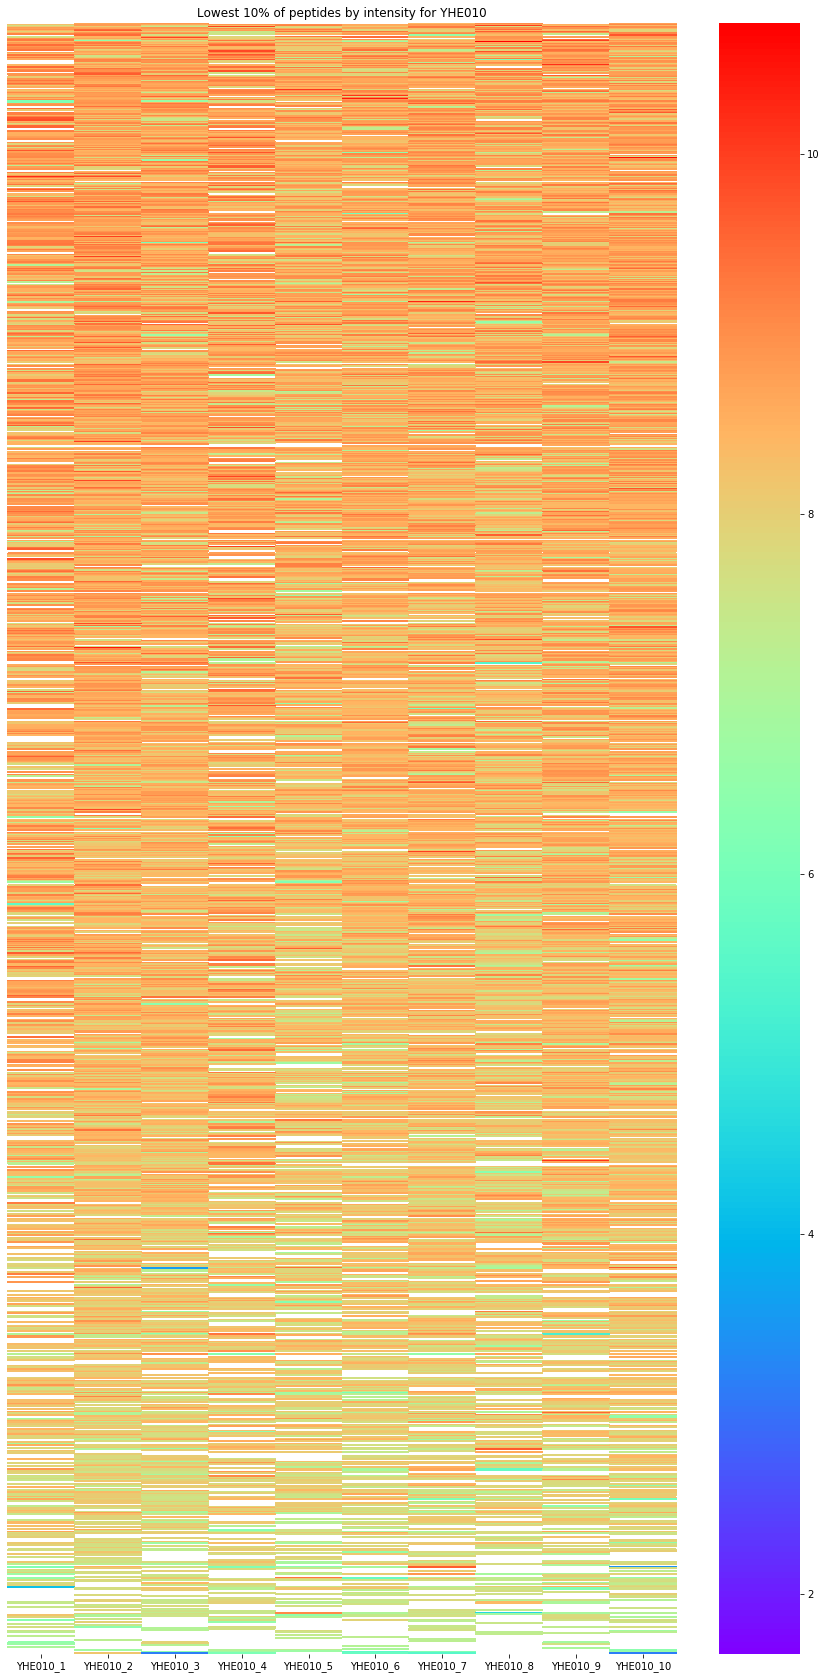

In [245]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010'.format(int(lower_proportion*100)))

#### plot YHE114

In [246]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [247]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114')

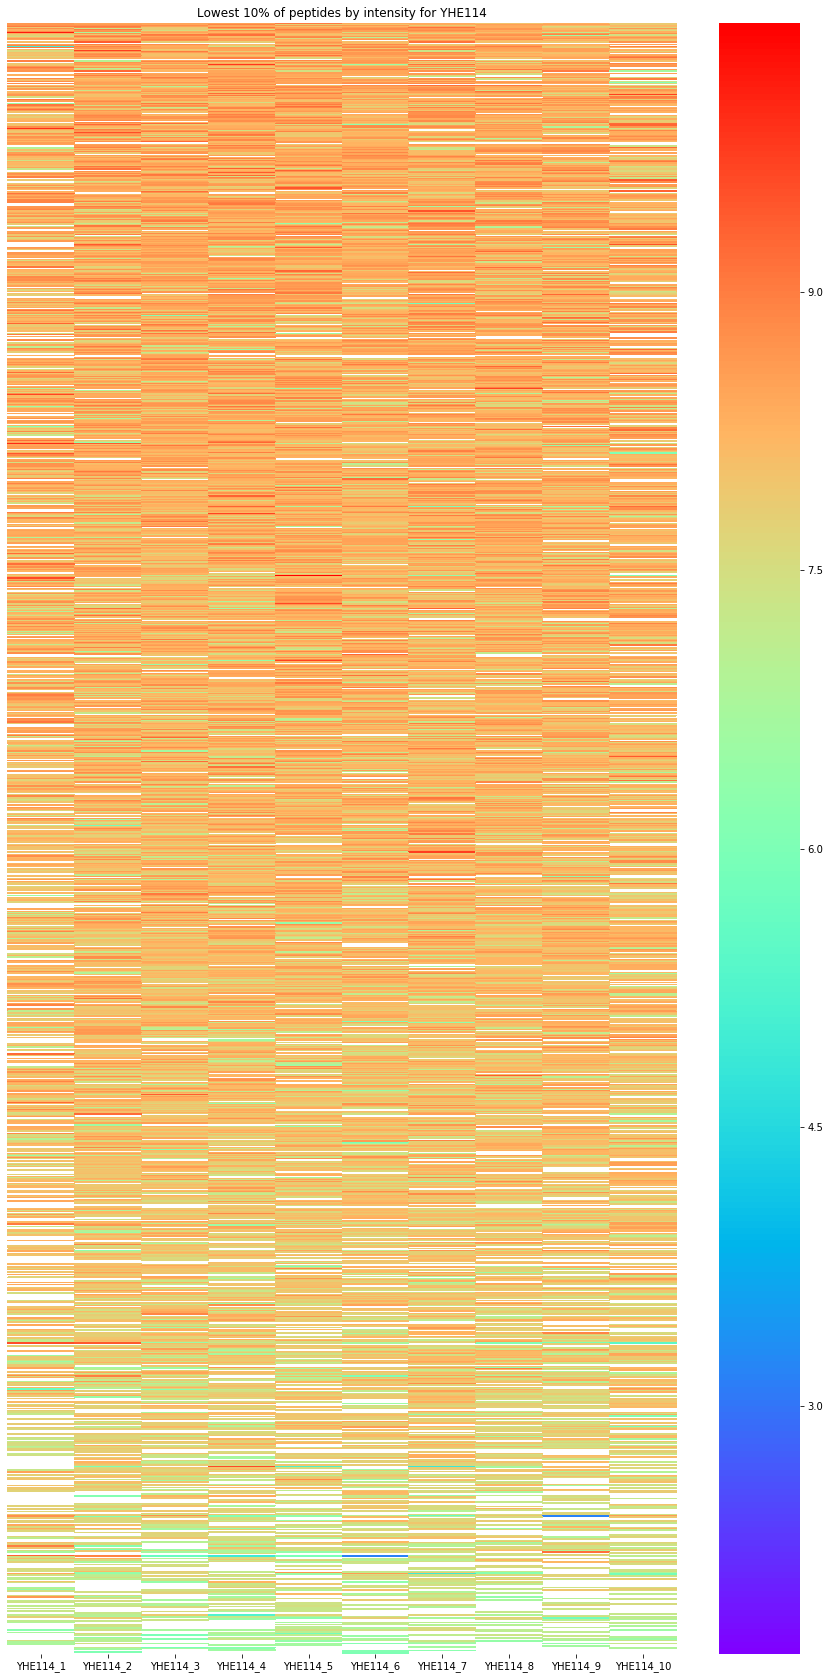

In [248]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114'.format(int(lower_proportion*100)))

#### plot YHE211

In [249]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [250]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211')

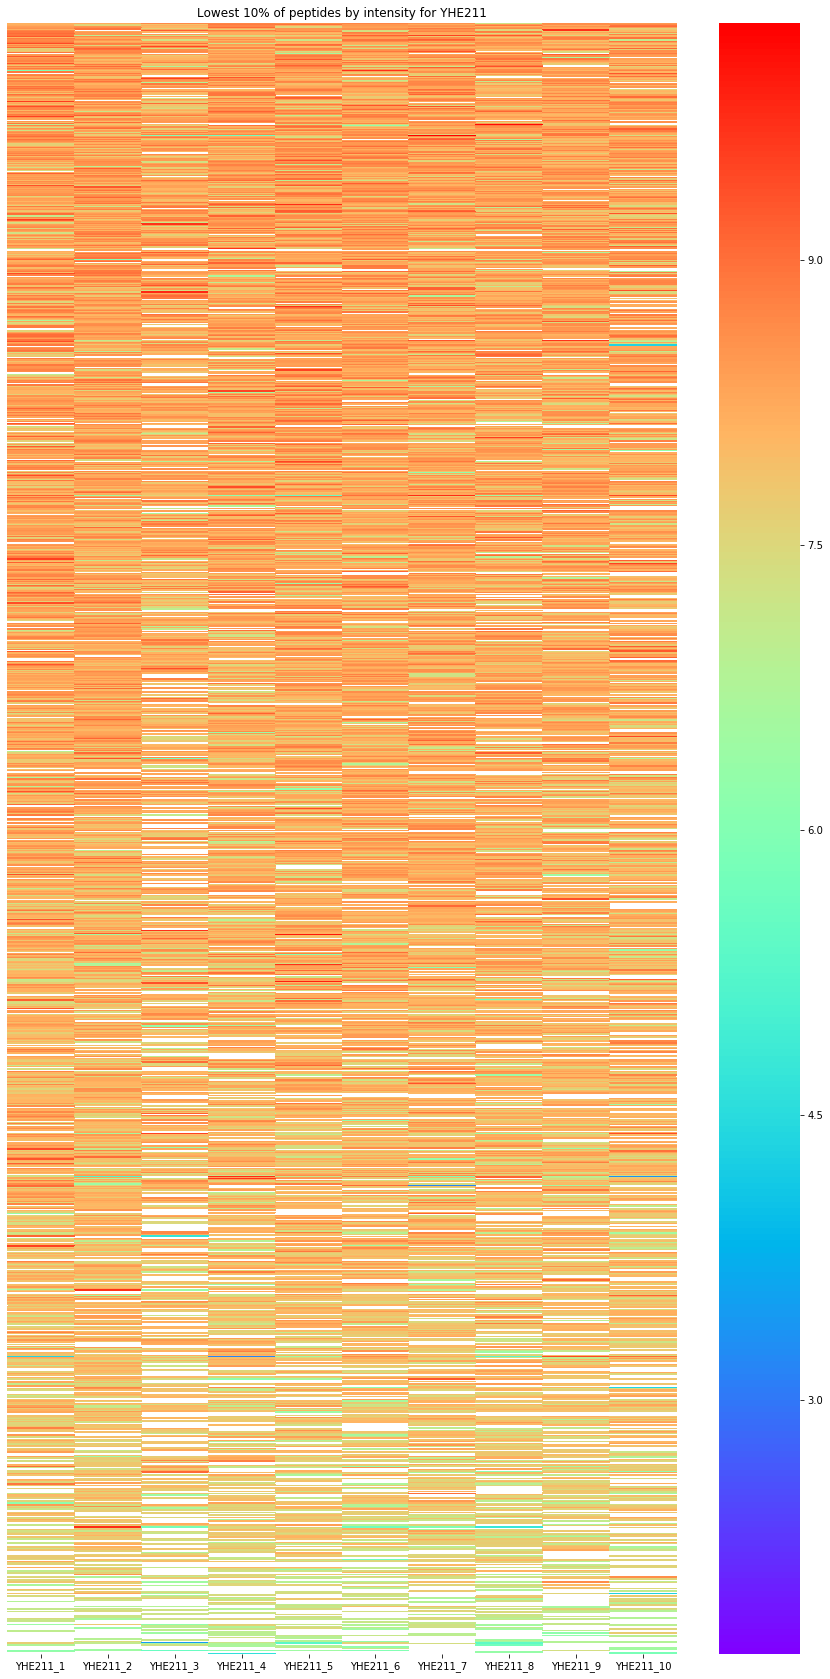

In [251]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211'.format(int(lower_proportion*100)))

## MaxQuant heatmaps

In [252]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [253]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','short_run_name','group','identified_in_file','score','intensity'])


In [254]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,short_run_name,group,identified_in_file,score,intensity
193825,LDLLAQLGGHSVAR,Unmodified,2,YHE211_6,YHE211,True,112.730,16592.0
58738,DPTVHDDVLELEMDELNR,Unmodified,2,YHE114_4,YHE114,True,61.067,94098.0
277805,PMEVFMCSVLK,Unmodified,2,YHE114_6,YHE114,False,67.897,9423.2
89516,ESDLPSAILQTSGVSEFTK,Unmodified,2,YHE010_5,YHE010,True,84.580,44718.0
136803,GTVLLADNVICPGAPDFLAHVR,Unmodified,3,YHE114_7,YHE114,True,85.513,19548.0


In [255]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [256]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [257]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [258]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [259]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [260]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [261]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MaxQuant (N=1613)')

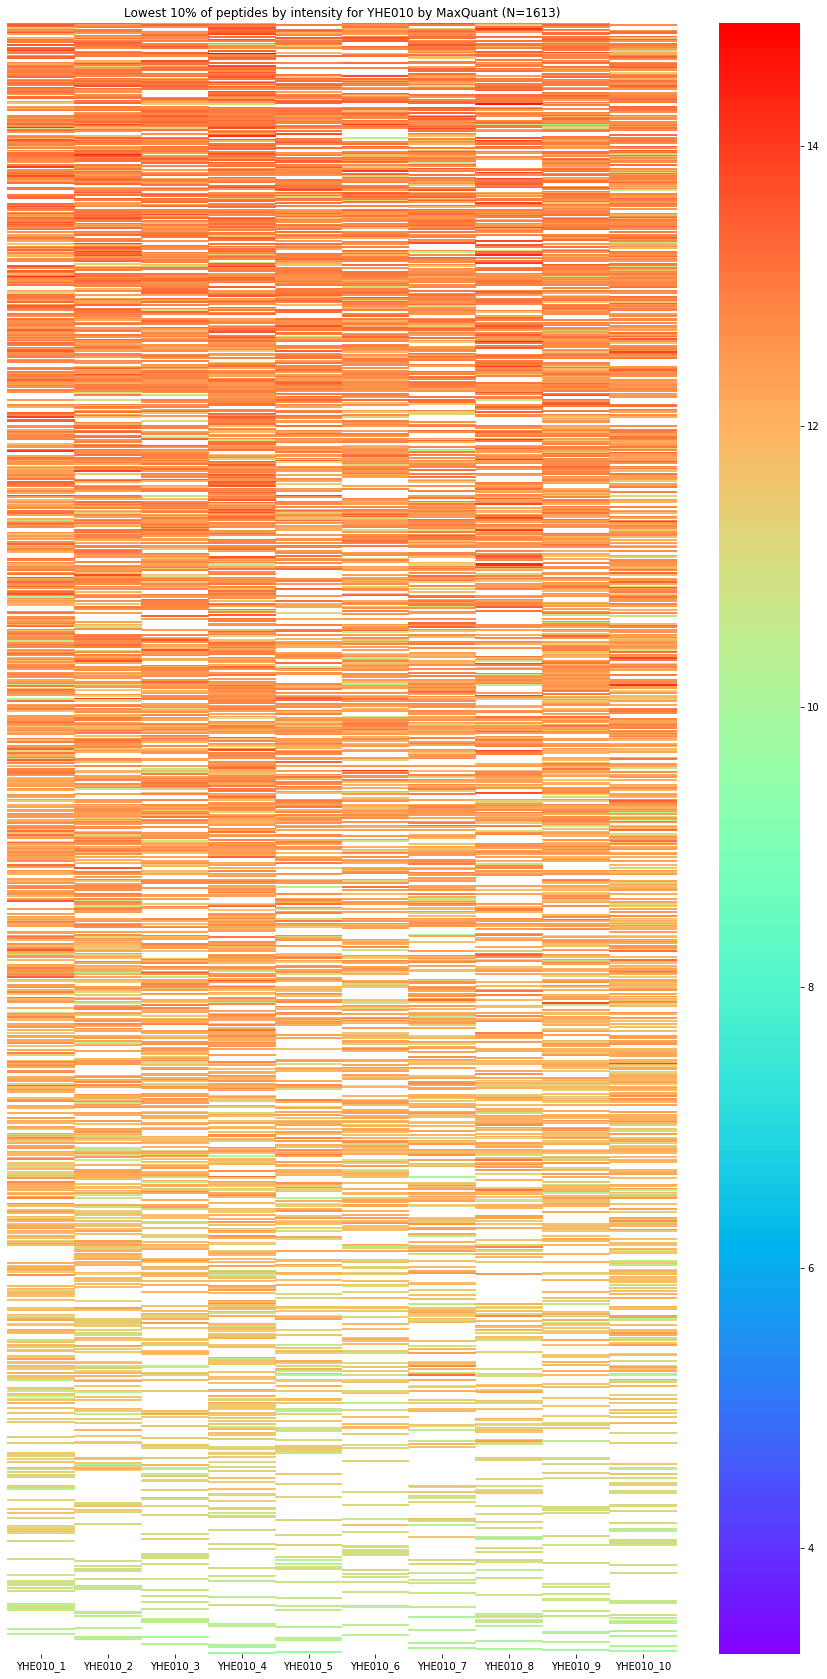

In [262]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [263]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [264]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MaxQuant (N=1811)')

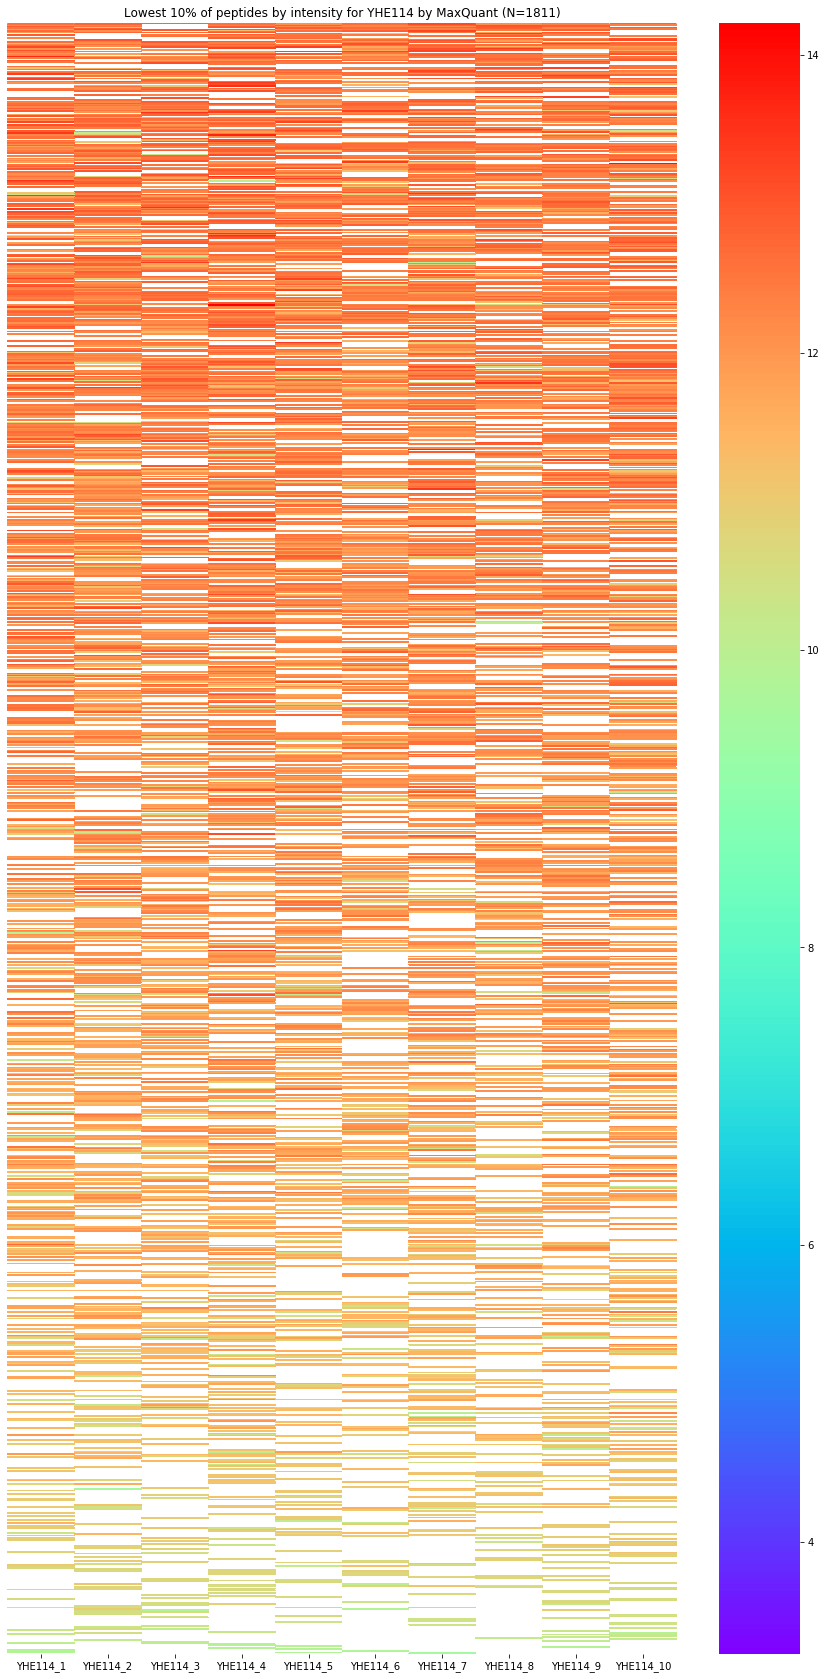

In [265]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [266]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [267]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1833)')

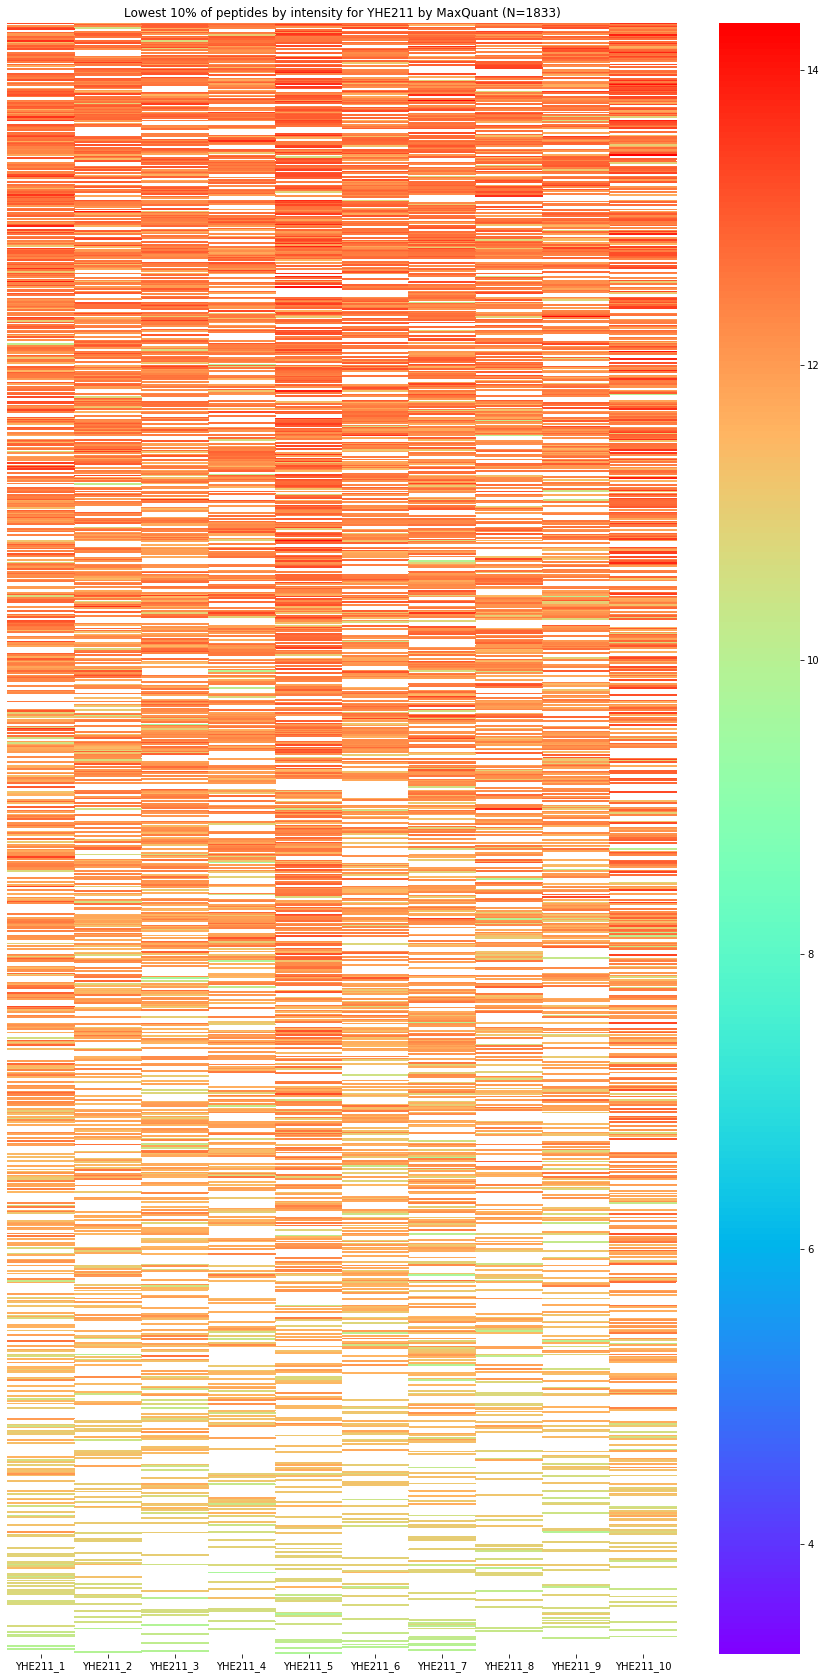

In [268]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [274]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE114') | (sequences_df.group == 'YHE211')]

In [275]:
number_of_yhe_runs_in_experiment = len(yhe_only_df.short_run_name.unique())
print('there are {} YHE runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 20 YHE runs in the experiment


In [286]:
number_of_unique_sequences_yhe = len(yhe_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_yhe

22715

In [276]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [277]:
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted

In [278]:
yhe_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
15559,"(QVEDLQATFSSIHSFQDLSSSILAQSR, 3)",20,QVEDLQATFSSIHSFQDLSSSILAQSR,3,0
11547,"(LLHLLLDDMPVKPYSDGEGGIEDENR, 3)",19,LLHLLLDDMPVKPYSDGEGGIEDENR,3,1
9907,"(ITELGLEHEPLR, 2)",20,ITELGLEHEPLR,2,0


In [303]:
run_count_l = []
for number_of_runs in range(1,number_of_yhe_runs_in_experiment+1):
    run_count_l.append((number_of_runs, len(yhe_sequence_occurences_df[yhe_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [304]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_yhe * 100

#### prepare MQ results

In [320]:
# unique peptides found across all runs
mq_unique_peptides_count = len(mq_results_df.drop_duplicates(subset=unique_peptide_key, keep='first', inplace=False))
mq_unique_peptides_count

20619

In [321]:
mq_results_df.sample(n=3)

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Taxonomy IDs,group
440045,WDPSGMLLASCSDDMTLK,18,Unmodified,NaN,NaN,NaN,0,0,0,sp|O60907|TBL1X_HUMAN;sp|Q9BQ87|TBL1Y_HUMAN,...,NaN,440045,380,18858,19195,NaN,NaN,None,NaN,YHE010
452673,YISLIYTNYEAGK,13,Unmodified,_YISLIYTNYEAGK_,NaN,NaN,0,0,0,sp|P09211|GSTP1_HUMAN,...,NaN,452673,831,19384,19734,291531.0,291531.0,None,NaN,YHE211
75143,EANNFLWPFK,10,Unmodified,_EANNFLWPFK_,NaN,NaN,0,0,0,sp|P18124|RL7_HUMAN,...,NaN,75143,1234,3266,3321,48715.0,48715.0,None,NaN,YHE010


In [322]:
mq_results_df['group'] = mq_results_df['Raw file'].apply(lambda x: x.split('_')[1])

In [323]:
mq_yhe_only_df = mq_results_df[(mq_results_df.group == 'YHE114') | (mq_results_df.group == 'YHE211')]

In [324]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_yhe_only_df.groupby(unique_peptide_key, as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df['Raw file'].unique())))
mq_yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [325]:
mq_modified_sequences_count_yhe_runs = len(mq_yhe_sequence_occurences_df)
mq_modified_sequences_count_yhe_runs

19151

In [313]:
run_count_l = []
for number_of_runs in range(1,number_of_yhe_runs_in_experiment+1):
    run_count_l.append((number_of_runs, len(mq_yhe_sequence_occurences_df[mq_yhe_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [326]:
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / mq_modified_sequences_count_yhe_runs * 100

#### now plot the results

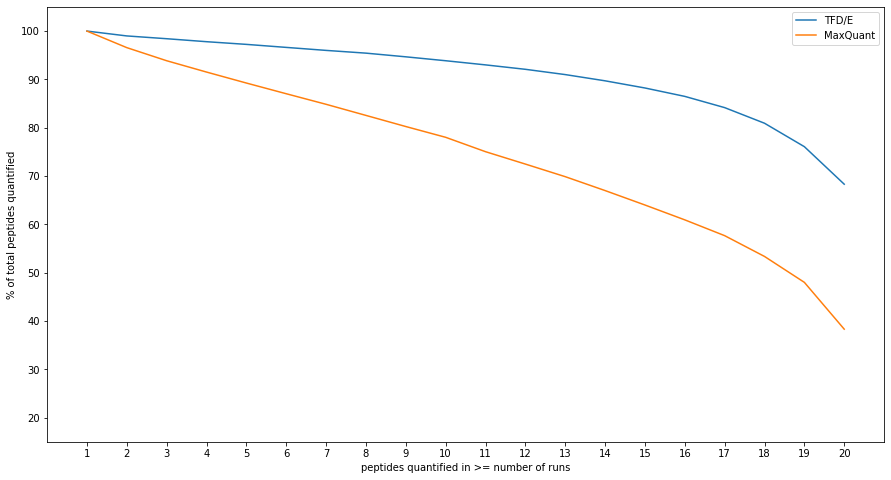

In [327]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
# plt.suptitle('Distribution of sequence identifications in the YHE runs for TFD_E')
# plt.title('total {} modified peptide sequences'.format(number_of_unique_sequences_yhe))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_yhe_runs_in_experiment+1), xlim=[0, number_of_yhe_runs_in_experiment+1])
plt.legend(loc="best")

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [359]:
yhe_only_df.sample(n=3)

,sequence,charge,id_perc_q_value,short_run_name,group,intensity
210661,HVTSEQEWDK,2,0.000006,YHE114_9,YHE114,351
262426,LDYNNIPTVVFSHPPIGTVGLTEDEAIHK,4,0.000004,YHE114_6,YHE114,2235
128147,EVVAASHELGQDYEHVTMLR,3,0.000004,YHE211_8,YHE211,759


In [372]:
# calculate the intensity mean for peptides without missing values
mean_intensities_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_yhe_runs_in_experiment:
        intensity_mean = group_df.intensity.mean()
        intensity_log_mean = np.log10(intensity_mean)
        mean_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_log_mean,'TFD/E'))

#### prepare MQ results

In [369]:
# calculate the intensity mean for peptides without missing values
for group_name,group_df in mq_yhe_only_df.groupby(unique_peptide_key, as_index=False):
    if len(group_df['Raw file'].unique()) == number_of_yhe_runs_in_experiment:
        intensity_mean = group_df.Intensity.mean()
        intensity_log_mean = np.log10(intensity_mean)
        mean_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_log_mean,'MaxQuant'))


#### consolidate the data

In [370]:
mean_intensities_df = pd.DataFrame(mean_intensities_l, columns=['sequence','intensity_log_mean','method'])

#### produce the plot

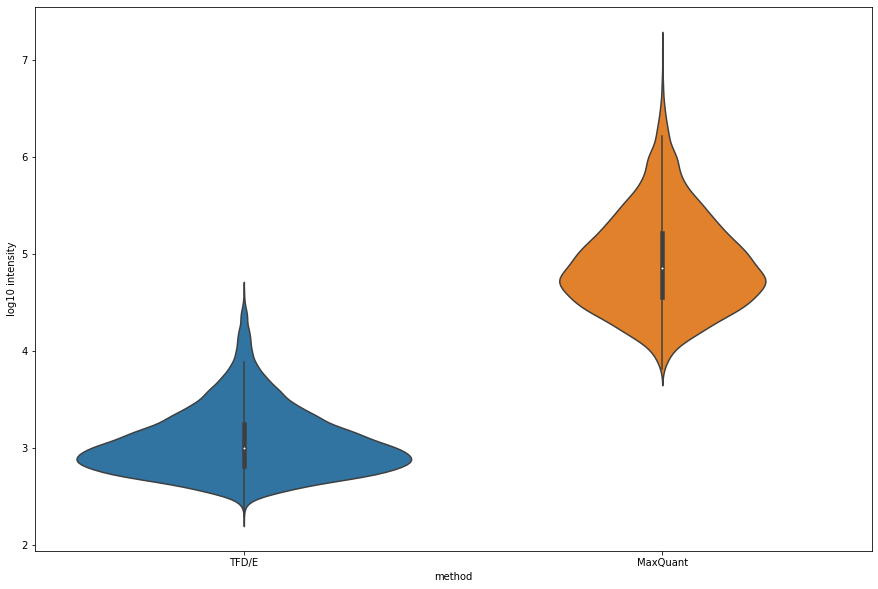

In [371]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=mean_intensities_df.method, y=mean_intensities_df.intensity_log_mean)
_ = plt.ylabel("log10 intensity")

In [373]:
# orders of magnitude
mean_intensities_df.groupby('method')['intensity_log_mean'].agg(np.ptp)

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


method
MaxQuant    3.305543
TFD/E       2.317422
Name: intensity_log_mean, dtype: float64

In [375]:
# number of peptides that have no missing values
mean_intensities_df.groupby('method')['intensity_log_mean'].count()

method
MaxQuant     7337
TFD/E       15517
Name: intensity_log_mean, dtype: int64